In [2]:
using Revise
using Flux, Tracker, DiffEqFlux, Optim
using ForwardDiff, ReverseDiff, FiniteDiff
using Plots

In [106]:
nx = 100
ω = 1.;

X = Vector(range(0, 1, length=nx))
X = hcat(X...)
Y = zeros(axes(X));

In [107]:
ann = Chain(Dense(1, 20, tanh), Dense(20, 1)) #|> track
p, re = Flux.destructure(ann)

(Float32[0.089479506, 0.42719868, -0.14466552, 0.47347268, -0.16012184, -0.21196142, 0.18346085, -0.41375834, -0.3924496, -0.522453  …  -0.48089364, -0.15117924, -0.4971763, -0.3738228, 0.12258449, 0.11158132, 0.20499375, -0.19107029, 0.5224294, 0.0], Flux.var"#12#14"{Chain{Tuple{Dense{typeof(tanh),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}}}}}(Chain(Dense(1, 20, tanh), Dense(20, 1))))

In [108]:
sol(x, p) = re(p)(x)

sol (generic function with 1 method)

In [109]:
θ = [vcat(X...); p];

In [113]:
function loss(θ)
    u0 = hcat(θ[1:nx]...)
    p = θ[nx+1:end]
    
    u(x) = 1 .+ re(p)(x) .* x
    ux(x) = Flux.Zygote.pullback(u, x)[2](ones(size(x)))[1]
    
    pred = ω .* u(u0) .+ ux(u0)
    loss = sum(abs2, pred)
    
    return loss, pred
end

loss (generic function with 2 methods)

In [116]:
cb = function (θ, l, pred; isplot=false)
    display(l)
    return false
end

#69 (generic function with 1 method)

In [124]:
res = DiffEqFlux.sciml_train(loss, θ, LBFGS(); cb=cb, maxiters=20, diffmode=DiffEqFlux.ForwardDiffMode()) # works for ForwardDiff & ReverseDiff
res = DiffEqFlux.sciml_train(loss, res.minimizer, LBFGS(); cb=cb, maxiters=20, diffmode=DiffEqFlux.ReverseDiffMode())

Dual{ForwardDiff.Tag{DiffEqFlux.var"#43#56"{typeof(loss)},Float64}}(29.217209087297825,-2.825132869039165,-1.808097529989287,-0.18180901921499792,-0.2437808061248804,67.88818890454583,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

Dual{ForwardDiff.Tag{DiffEqFlux.var"#43#56"{typeof(loss)},Float64}}(27.876980708397475,0.7841038233730154,0.7920144862057206,0.2088857637747247,-0.008036346504163886,57.387795153395444,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

Dual{ForwardDiff.Tag{DiffEqFlux.var"#43#56"{typeof(loss)},Float64}}(20.009057249594235,27.860662771526986,20.75192643882054,2.3759998907688464,3.6428509724146196,-27.57465922351672,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

Dual{ForwardDiff.Tag{DiffEqFlux.var"#43#56"{typeof(loss)},Float64}}(0.556785047418887,-8.456011506849718,-6.394967636828099,-0.6281994588820324,-1.2384912473464467,21.082693007910493,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

Dual{ForwardDiff.Tag{DiffEqFlux.var"#43#56"{typeof(loss)},Float64}}(0.0433375983602025,-0.012376990185989251,-0.018280386381704955,-0.006603857633301028,0.0037911274461039975,0.038839606068715074,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

Dual{ForwardDiff.Tag{DiffEqFlux.var"#43#56"{typeof(loss)},Float64}}(0.04325905667926127,-0.010615620408685564,-0.020097778410380032,-0.0005273752627730944,-0.010361337838023699,0.12205013204741373,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

Dual{ForwardDiff.Tag{DiffEqFlux.var"#43#56"{typeof(loss)},Float64}}(0.019314844781752372,0.6078998365200938,0.4538263250519105,0.01367992537295192,0.17237831266425244,-1.4452144211336524,0.0,0.0,0.0,0.0,0.0,0.0,0.0)

TrackedReal<JGj>(0.019314844781752313, 0.0, 8pa, ---)

TrackedReal<GCD>(0.016599107209160437, 0.0, 1L9, ---)

TrackedReal<4bi>(0.01620838944302926, 0.0, 3Fv, ---)

TrackedReal<7LN>(0.00516216091627471, 0.0, K7x, ---)

TrackedReal<LR1>(0.0031058589243607567, 0.0, GSx, ---)

TrackedReal<HJt>(0.0017633441401913145, 0.0, AF2, ---)

TrackedReal<5C1>(0.0017148796802501074, 0.0, 8kC, ---)

 * Status: failure

 * Candidate solution
    Final objective value:     1.714880e-03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.36e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.85e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.83e-02 ≰ 0.0e+00
    |g(x)|                 = 7.40e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    6
    f(x) calls:    21
    ∇f(x) calls:   21


In [121]:
res = DiffEqFlux.sciml_train(loss, θ, LBFGS(); cb=cb, maxiters=20, diffmode=DiffEqFlux.ZygoteDiffMode()) # doesn't work for Zygote

ErrorException: Can't differentiate foreigncall expression

In [128]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(); cb=cb, maxiters=20, diffmode=DiffEqFlux.ReverseDiffMode()) # and  doesn't work for Flux optimizers

MethodError: MethodError: no method matching sciml_train(::typeof(loss), ::Array{Float64,1}, ::ADAM, ::Base.Iterators.Cycle{Tuple{DiffEqFlux.NullData}}; cb=var"#69#71"(), maxiters=20, diffmode=DiffEqFlux.ReverseDiffMode())
Closest candidates are:
  sciml_train(::Any, ::Any, ::Any, ::Any; cb, maxiters, progress, save_best) at /home/vavrines/.julia/packages/DiffEqFlux/FZMwP/src/train.jl:77 got unsupported keyword argument "diffmode"
  sciml_train(::Any, ::Any, !Matched::Optim.AbstractOptimizer, ::Any; cb, maxiters, diffmode, kwargs...) at /home/vavrines/.julia/packages/DiffEqFlux/FZMwP/src/train.jl:163
  sciml_train(::Any, ::Any, !Matched::Optim.AbstractConstrainedOptimizer, ::Any; lower_bounds, upper_bounds, cb, maxiters) at /home/vavrines/.julia/packages/DiffEqFlux/FZMwP/src/train.jl:279 got unsupported keyword argument "diffmode"
  ...

In [125]:
xTest = Vector(range(0., 1., length=33))
xTest = hcat(xTest...)
yTest = exp.(-xTest)
yPred = 1 .+ re(res.minimizer[nx+1:end])(xTest) .* xTest

1×33 Array{Float64,2}:
 1.0  0.969815  0.940386  0.911717  0.883809  …  0.392242  0.379935  0.367886

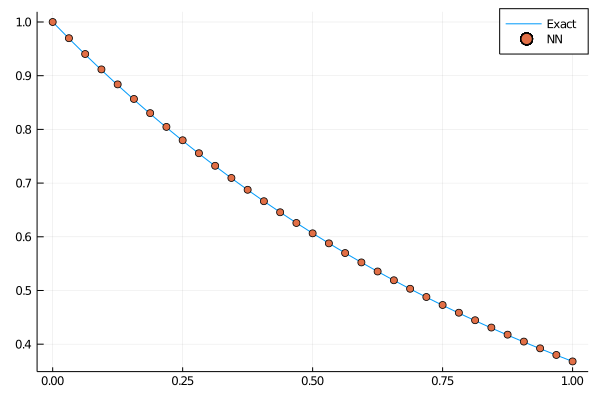

In [127]:
plot(xTest', yTest', label="Exact")
scatter!(xTest', yPred', label="NN")